# Precipitate Property and Unit Model Test/Demo

This verifies the equilibrium precipitate property package against the paper "Effects of contaminant metal ions on precipitation recovery of rare earth elements using oxalic acid" (W. Zhang, A. Noble, B. Ji, and Q. Li 2022).  The intention of property and the unit model is to provide calcuation methods similar to software suce as [PHREEQC](https://www.usgs.gov/software/phreeqc-version-3) or [MinTEQ](https://vminteq.com) providing an equlibrium model for precipitation. 

## Basic Boilerplate and Setup

In [1]:
from math import log10
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import precipitator

expression symbols from pyomo.core.expr  (deprecated in 6.6.2.dev0) (called
from <frozen importlib._bootstrap>:241)


In [2]:
# Change the pyomo logging level to avoid scaling suffix warnings
import logging
logging.getLogger("pyomo").setLevel(logging.ERROR)

In [3]:
# Solve initial model and get model and solver objects 
m, solver_obj = precipitator.main()
# If the model doesn't solve print the constraint names and 
# residuals, for constraints with high residuals 
for c in m.component_data_objects(pyo.Constraint):
    if abs(c.body() - c.lower()) > 1e-5:
        print(f"{c} -- {abs(c.body() - c.lower())}")

Ipopt 3.13.2: nlp_scaling_method=user-scaling
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
tol=1e-08
max_iter=50
option_file_name=/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmppsy3nmzj_ipopt.opt

Using option file "/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmppsy3nmzj_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for 

In [4]:
# Check the pH for the inital model specs based on inlet mass
# balance
m.fs.unit.pH.display()

pH : Size=1, Index=fs._time, ReferenceTo=fs.unit.cv_aqueous.properties_out[:].pH
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : 1.0934490020823806 :  None : False : False :  Reals


In [5]:
# Plots in the paper of recovery as a function of pH run from 
# a pH of 1 to 5, so create a vector of pHs to run model at
pH_vec = np.linspace(1, 5, 100)

In [6]:
# Respecify the model to unfix the H^+ in and fix the pH.  This 
# specification should work at low pH where you need to add acid, 
# but at higher pH where you need to add a base a different 
# specification is needed. We'll revisit this when looking at the
# affect of Fe^3+ at the end of the notebook.
m.fs.unit.pH.fix(1)
m.fs.unit.cv_aqueous.properties_in[0].log10_molality_comp["H^+"].unfix()
# Make sure the model solves and degrees of freedom are good. 
res = solver_obj.solve(m, tee=True)
# Clone the model for an easy way to get back to the initial model specs
# to start each section.
m_orig = m.clone()

Ipopt 3.13.2: nlp_scaling_method=user-scaling
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
tol=1e-08
max_iter=50
option_file_name=/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmp93gi0cy3_ipopt.opt

Using option file "/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmp93gi0cy3_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for 

In [7]:
def run_oxconc(other=None):
    """ Run simulations of the pH range and save a couple key results
    """
    rec_ce_vec = [[], [], [], []]
    rec_other_vec = [[], [], [], []]
    oxalate_conc = [1e-4, 2e-4, 3e-4, 4e-4]
    prop_aq_in = m.fs.unit.cv_aqueous.properties_in[0]
    for i, oc in enumerate(oxalate_conc):
        for pH in pH_vec:
            m.fs.unit.pH.fix(pH)
            prop_aq_in.log10_molality_comp["C2O4^2-"].fix(log10(oc))
            try:
                res = solver_obj.solve(m)
                if res.solver.termination_condition != pyo.TerminationCondition.optimal:
                    print(f"pH = {pH}")
                    print(res.solver.termination_condition)
                    for c in m.component_data_objects(pyo.Constraint):
                        if abs(c.body() - c.lower()) > 1e-5:
                            print(f"{c} -- {abs(c.body() - c.lower())}")
            except:
                print("Solver Exception")
            rec_ce_vec[i].append(pyo.value(100*m.fs.unit.recovery[0, "Ce^3+"]))
            if other is not None:
                rec_other_vec[i].append(pyo.value(100*m.fs.unit.recovery[0, other]))
    return rec_ce_vec, oxalate_conc, rec_other_vec

def plot_ce_rec(rec_vec, ylabel="Ce^3+ Recovery (%)", title="My Plot Title"):
    """ Plot recovery as a function of pH and oxalate concentration
    """
    plt.plot(pH_vec, rec_vec[0], label=r"1e-4 molality oxalate")
    plt.plot(pH_vec, rec_vec[1], label=r"2e-4 molality oxalate")
    plt.plot(pH_vec, rec_vec[2], label=r"3e-4 molality oxalate")
    plt.plot(pH_vec, rec_vec[3], label=r"4e-4 molality oxalate")
    plt.xlabel("pH")
    plt.ylabel(ylabel)
    plt.ylim((0,100))
    plt.title(title)
    leg = plt.legend()

## Affect of Oxalate Concentration with No Contaminant Metals

In [8]:
rec_ce_vec, oxalate_conc, re_other_vec = run_oxconc()

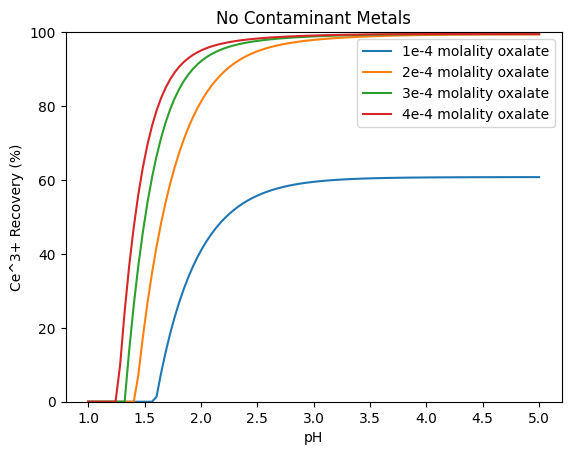

In [9]:
plot_ce_rec(rec_ce_vec, title="No Contaminant Metals")

## Affect of Al<sup>3+</sup>

In [10]:
m = m_orig.clone()
m.fs.unit.cv_aqueous.properties_in[0].log10_molality_comp["Al^3+"] = -4
res = solver_obj.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
tol=1e-08
max_iter=50
option_file_name=/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmpqmldjm2p_ipopt.opt

Using option file "/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmpqmldjm2p_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for 

In [11]:
rec_ce_vec, oxalate_conc, rec_other_vec = run_oxconc(other="Al^3+")

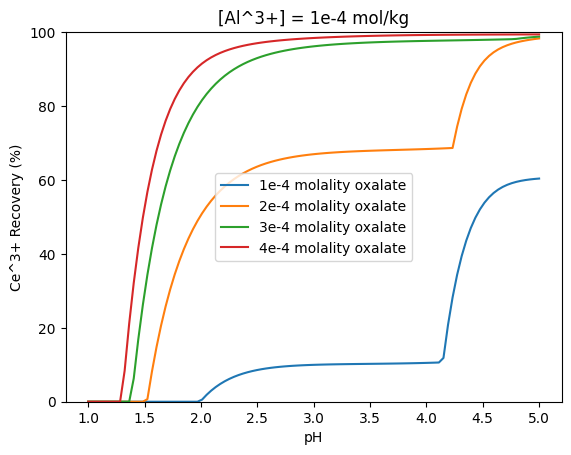

In [12]:
plot_ce_rec(rec_ce_vec, title="[Al^3+] = 1e-4 mol/kg")

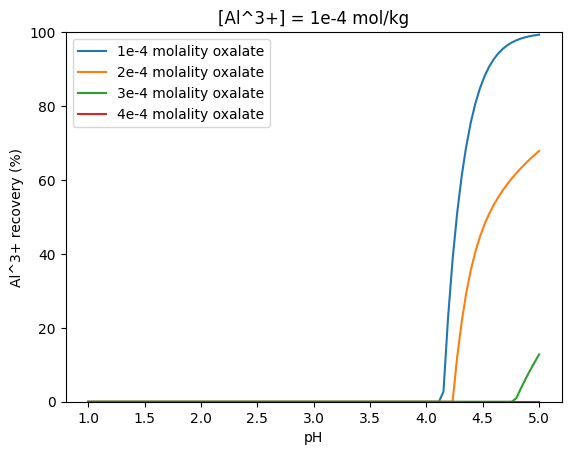

In [13]:
plot_ce_rec(rec_other_vec, ylabel="Al^3+ recovery (%)", title="[Al^3+] = 1e-4 mol/kg")

## Affect of Fe<sup>3+</sup>

In [14]:
m = m_orig.clone()
m.fs.unit.cv_aqueous.properties_in[0].log10_molality_comp["Fe^3+"] = -4

# The formation of Fe2O3 produces H^+, so in this example you'll need to
# add OH^- to get to the higher pH levels.  Previously we freed the H^+
# concentration in the inlet, but to cover the pH range, you need to add
# both H^+ and OH^- depending on pH. The H^+ key concentration is 
# negative when more OH^- comes in than H^+, so this varaible covers both
# addition of H^+ and OH^-. To decouple the H^+ concentration from the
# inlet H^+ and OH^- amounts.  Decativate the constraint below. 
m.fs.unit.molality_key_comp_eqn[0, "H^+"].deactivate()
res = solver_obj.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
tol=1e-08
max_iter=50
option_file_name=/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmpp6vz1d17_ipopt.opt

Using option file "/var/folders/8t/jrcb2krj6898r162wv32s0xw0000gn/T/tmpp6vz1d17_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for 

In [15]:
rec_ce_vec, oxalate_conc, rec_other_vec = run_oxconc(other="Fe^3+")

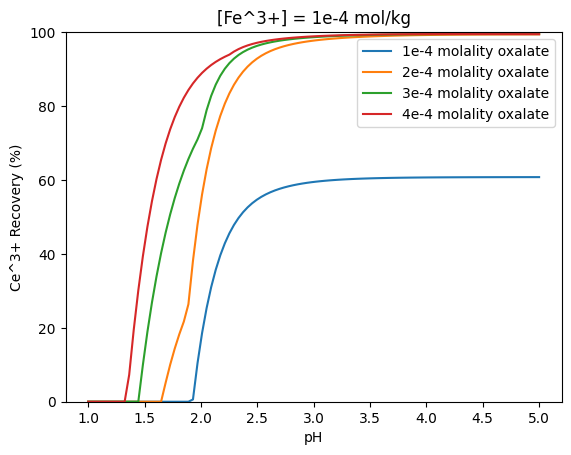

In [16]:
plot_ce_rec(rec_ce_vec, title="[Fe^3+] = 1e-4 mol/kg")

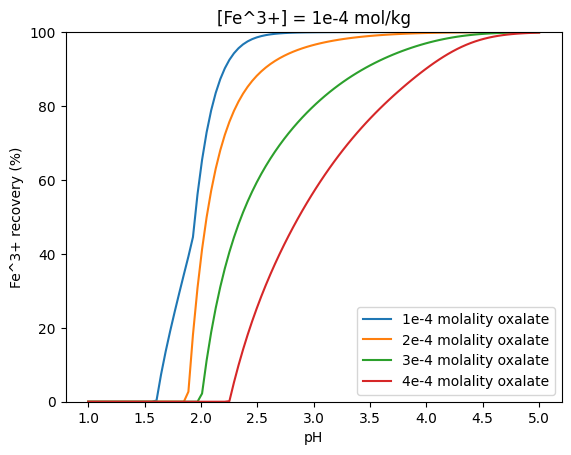

In [17]:
plot_ce_rec(rec_other_vec, ylabel="Fe^3+ recovery (%)", title="[Fe^3+] = 1e-4 mol/kg")